In [12]:
SAMPLE_T = 128  # Time steps per sample
SHD_TIMESTEP = 1e-6  # Time step of SHD dataset
SHD_CHANNELS = 700  # Number of input channels in the SHD dataset
NET_CHANNELS = 128  # Number of input channels in the network
NET_DT = 1 / SAMPLE_T  # Time step for network
BATCH_SIZE = 256  # Batch size
NUM_EPOCHS = 100  # Number of training epochs
NUM_HIDDEN = 64  # Number of hidden units in the network

# Set the input and output shapes
OBS_SHAPE = (NET_CHANNELS,)
ACT_SHAPE = (20,)

## Visualizing Raster Plots (Spike Trains)

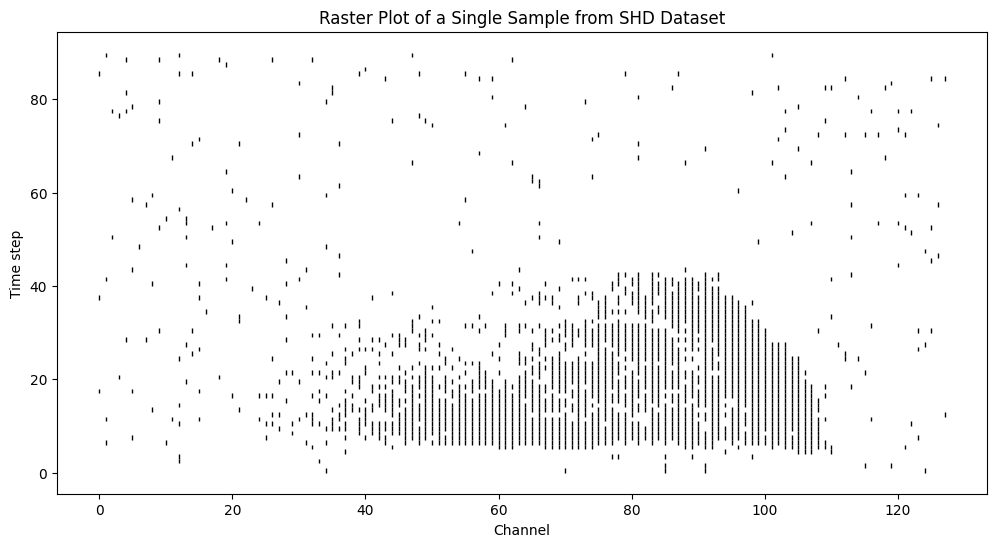

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tonic import datasets, transforms


class _SHD2Raster():
    """ 
    Tool for rastering SHD samples into frames. Packs bits along the temporal axis for memory efficiency. This means
        that the used will have to apply jnp.unpackbits(events, axis=<time axis>) prior to feeding the data to the network.
    """

    def __init__(self, encoding_dim, sample_T = 100):
        self.encoding_dim = encoding_dim
        self.sample_T = sample_T
        
    def __call__(self, events):
        # tensor has dimensions (time_steps, encoding_dim)
        tensor = np.zeros((events["t"].max()+1, self.encoding_dim), dtype=int)
        np.add.at(tensor, (events["t"], events["x"]), 1)
        #return tensor[:self.sample_T,:]
        tensor = tensor[:self.sample_T,:]
        tensor = np.minimum(tensor, 1)
        #tensor = np.packbits(tensor, axis=0) pytorch does not have an unpack feature.
        return tensor
    
# Load dataset
transform = transforms.Compose([
    transforms.Downsample(time_factor=SHD_TIMESTEP / NET_DT, spatial_factor=NET_CHANNELS / SHD_CHANNELS),
    _SHD2Raster(NET_CHANNELS, sample_T=SAMPLE_T)
])

# Load a subset of the dataset (for visualization purposes)
train_dataset = datasets.SHD("../data", train=True, transform=transform)
test_dataset = datasets.SHD("../data", train=False, transform=transform)

# Select a single sample (we'll visualize its spikes)
sample_data, sample_labels = train_dataset[0]

# Plot raster plot of the first sample
time_steps, channels = sample_data.shape
plt.figure(figsize=(12, 6))

# Raster plot
for t in range(time_steps):
    spikes = np.where(sample_data[t, :] == 1)[0]  # Find channels with spikes at time step t
    plt.vlines(spikes, t, t + 1, color='black', linewidth=1)

plt.xlabel("Channel")
plt.ylabel("Time step")
plt.title("Raster Plot of a Single Sample from SHD Dataset")
plt.show()

## Visualizing Spike Patterns for Multiple Channels

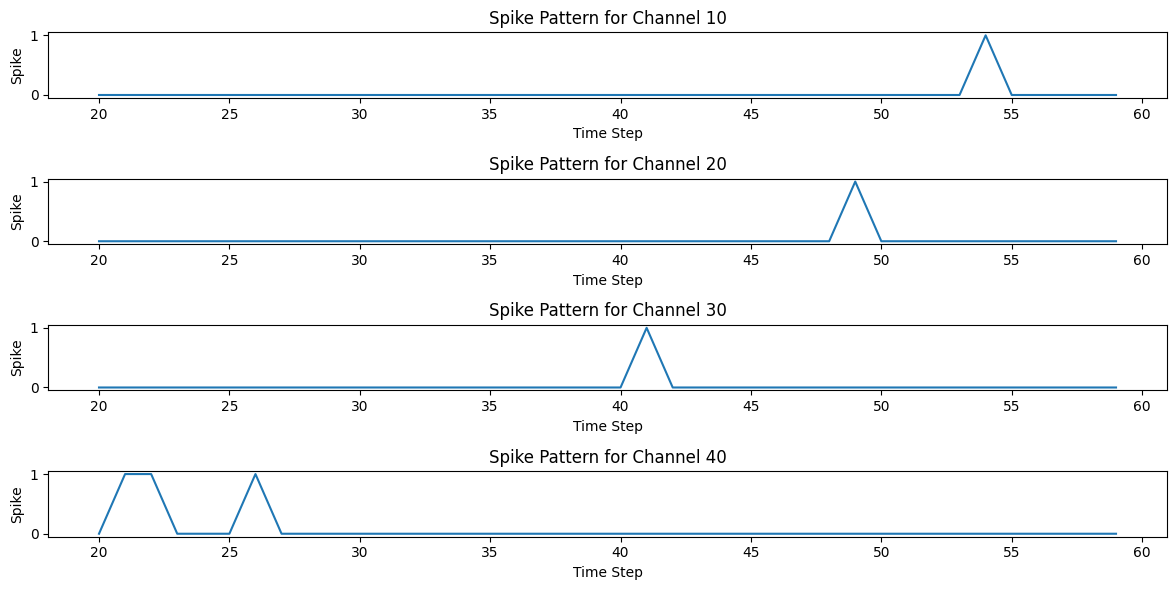

In [19]:
# Select a specific time window and visualize spike patterns for multiple channels
time_window = (20, 60)  # Time steps from 20 to 60
channels_to_plot = [10, 20, 30, 40]  # Channels you want to visualize

plt.figure(figsize=(12, 6))
for i, channel in enumerate(channels_to_plot):
    spikes = sample_data[time_window[0]:time_window[1], channel]  # Get spikes for this channel in the time window
    plt.subplot(len(channels_to_plot), 1, i + 1)
    plt.plot(range(time_window[0], time_window[1]), spikes, label=f'Channel {channel}')
    plt.xlabel("Time Step")
    plt.ylabel("Spike")
    plt.title(f"Spike Pattern for Channel {channel}")

plt.tight_layout()
plt.show()

## Heatmaps of Spikes

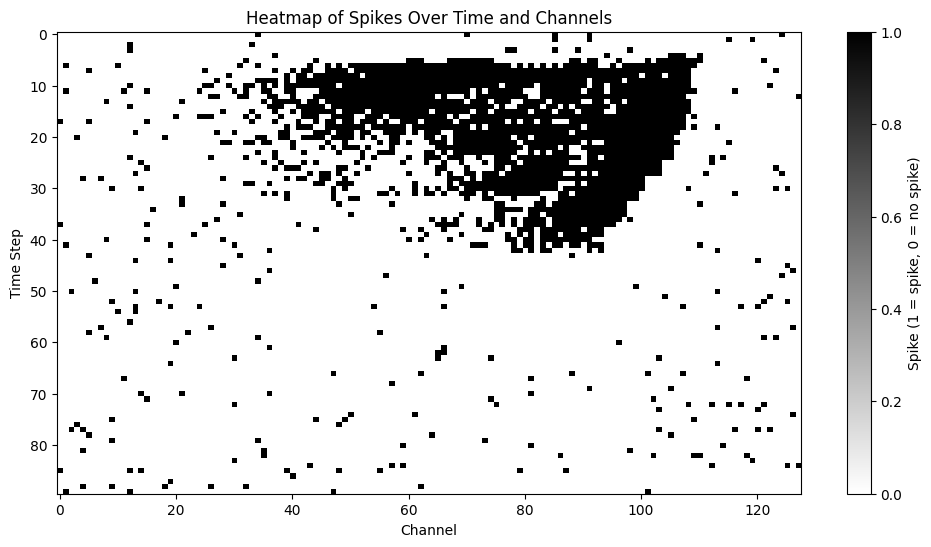

In [20]:
import matplotlib.pyplot as plt

# Create a heatmap of the spikes for the first sample
plt.figure(figsize=(12, 6))
plt.imshow(sample_data, aspect="auto", cmap="binary", interpolation="none")
plt.colorbar(label="Spike (1 = spike, 0 = no spike)")
plt.xlabel("Channel")
plt.ylabel("Time Step")
plt.title("Heatmap of Spikes Over Time and Channels")
plt.show()

## Spike Train Per Channel (Overlaid)

This plot shows you the temporal relationship between spike events in different channels. Overlapping spikes between channels could indicate simultaneous neuron activity

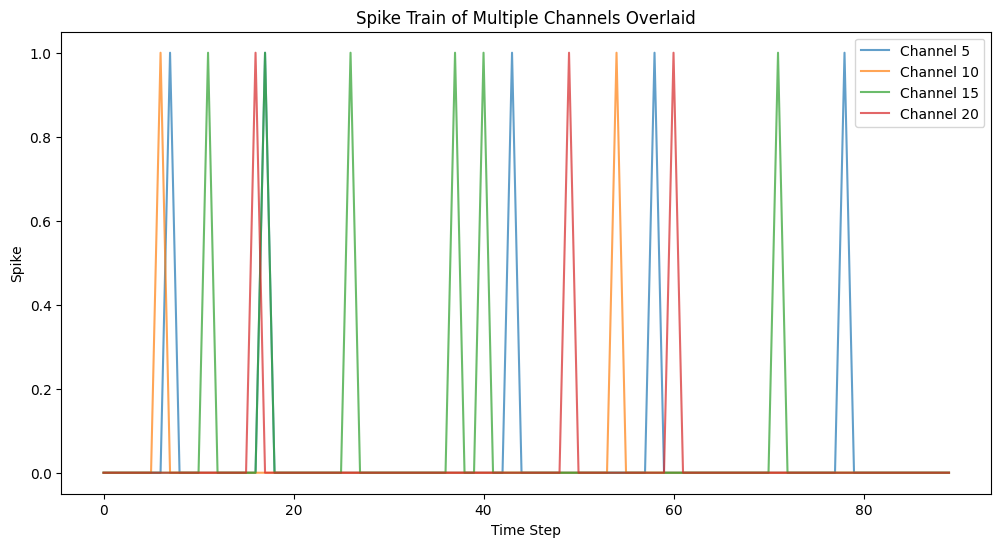

In [22]:
import matplotlib.pyplot as plt

# Define the number of channels you want to visualize
channels_to_plot = [5, 10, 15, 20]

plt.figure(figsize=(12, 6))

# Plot the spike train for each selected channel overlaid
for channel in channels_to_plot:
    spikes = sample_data[:, channel]  # Spike train for the selected channel
    plt.plot(range(time_steps), spikes, label=f"Channel {channel}", alpha=0.7)

plt.xlabel("Time Step")
plt.ylabel("Spike")
plt.title("Spike Train of Multiple Channels Overlaid")
plt.legend()
plt.show()

##  Spike Density Plot

The total number of spikes occurring at each time step across all channels. This gives a smoother view of neural activity. This plot helps visualize the overall firing activity of the network, showing the periods of high and low neural activity.

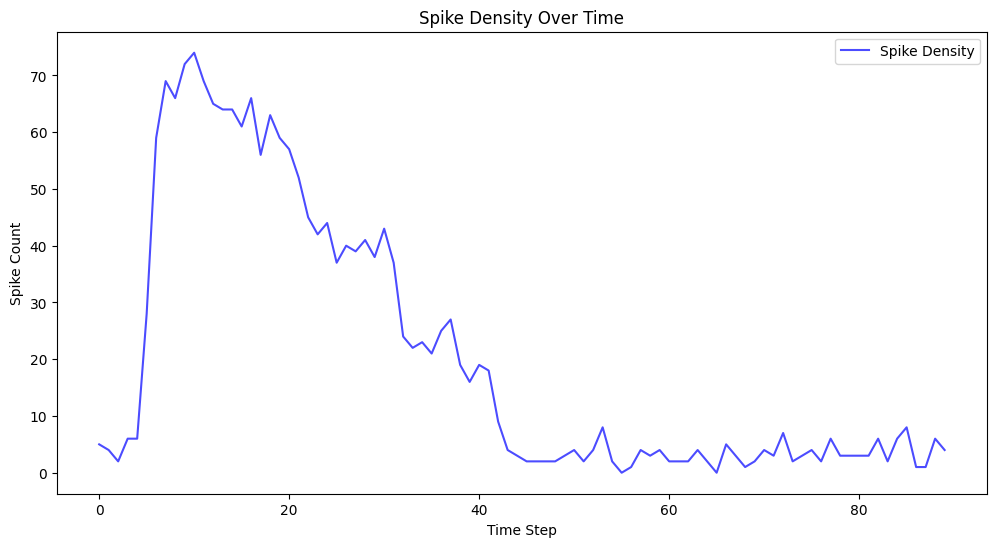

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate spike density (total spikes per time step)
spike_density = np.sum(sample_data, axis=1)  # Sum spikes across all channels for each time step

plt.figure(figsize=(12, 6))
plt.plot(range(time_steps), spike_density, color="b", label="Spike Density", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Spike Count")
plt.title("Spike Density Over Time")
plt.legend()
plt.show()

## Correlation Between Channels (Spike Coincidence)

explores the correlation between different channels, i.e., how similarly two channels spike over time. High correlation could indicate neurons firing together or shared input. This heatmap will show how closely different channels spike together, and whether there are clusters of neurons that are more likely to spike simultaneously. Highly correlated channels may reflect neurons that are part of a functional network.

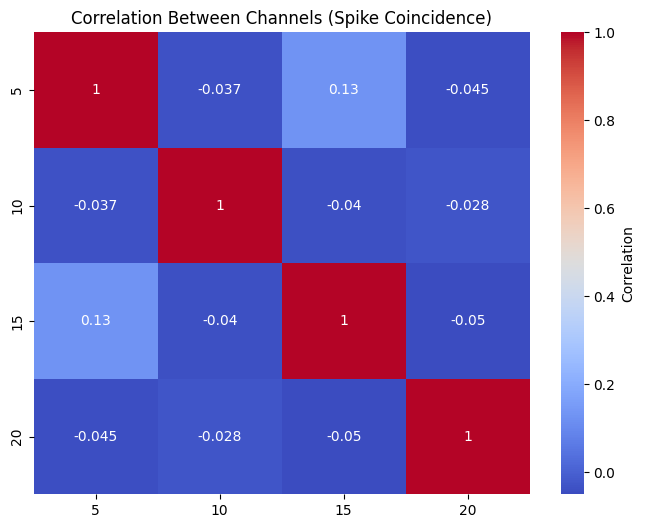

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select a subset of channels to check for correlation
channels_to_correlate = [5, 10, 15, 20]
spike_train_subset = sample_data[:, channels_to_correlate]

# Compute correlation matrix
correlation_matrix = np.corrcoef(spike_train_subset.T)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'Correlation'}, xticklabels=channels_to_correlate, yticklabels=channels_to_correlate)
plt.title("Correlation Between Channels (Spike Coincidence)")
plt.show()

## Visualizing Temporal Structure of Classes

 how different classes behave temporally across neurons or channels, you can visualize how spike patterns differ between classes. This plot shows how the spike patterns differ across different classes, which may help to understand if certain classes have distinct spiking patterns.

IndexError: index 79 is out of bounds for axis 0 with size 79

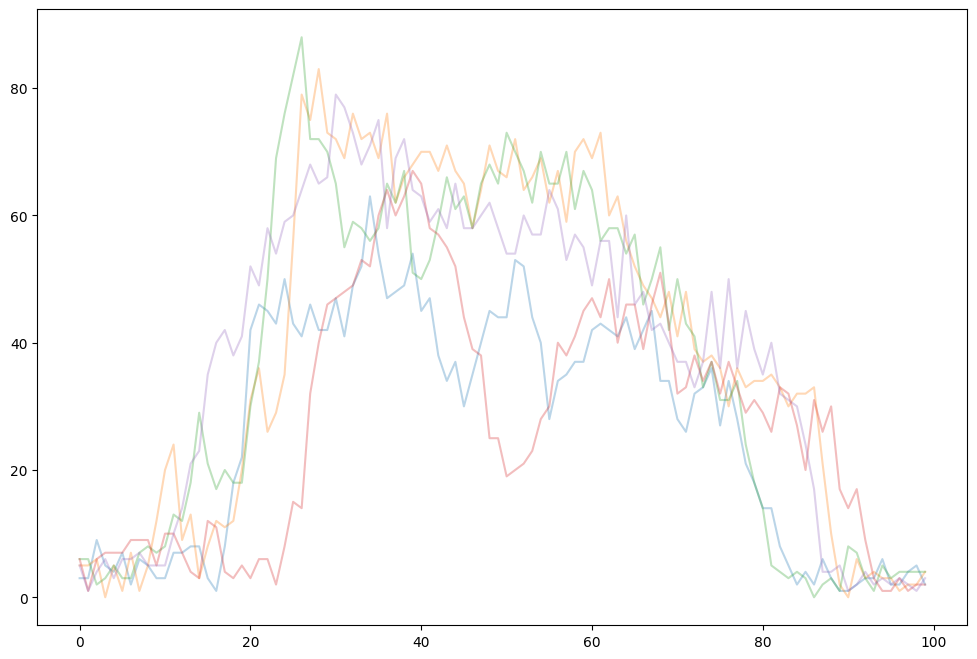

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Select a subset of classes (e.g., first 3 classes)
classes_to_plot = [0, 1, 2]
time_steps_to_plot = range(100)  # Look at the first 100 time steps

plt.figure(figsize=(12, 8))

# Plot spike trains for each class
for class_id in classes_to_plot:
    class_samples = [x for x, y in train_dataset if y == class_id]  # Samples of the given class
    for sample in class_samples[:5]:  # Plot the first 5 samples for each class
        spikes = sample[time_steps_to_plot, :]  # Get spikes over the time window for this sample
        plt.plot(time_steps_to_plot, np.sum(spikes, axis=1), label=f"Class {class_id} Sample", alpha=0.3)

plt.xlabel("Time Step")
plt.ylabel("Spike Count")
plt.title("Spike Patterns for Different Classes (First 5 Samples)")
plt.legend()
plt.show()

## Spiking Neuron Activity Heatmap (Average Activity Across Classes)

To get a sense of how each neuron behaves on average across all time steps, you can generate a heatmap that shows the average spike count for each channel across all time steps and classes. This heatmap shows which channels are more active on average, helping to identify which neurons or channels tend to fire more frequently. You can compare the heatmap for different classes or time windows to see if certain channels are more active in certain conditions.

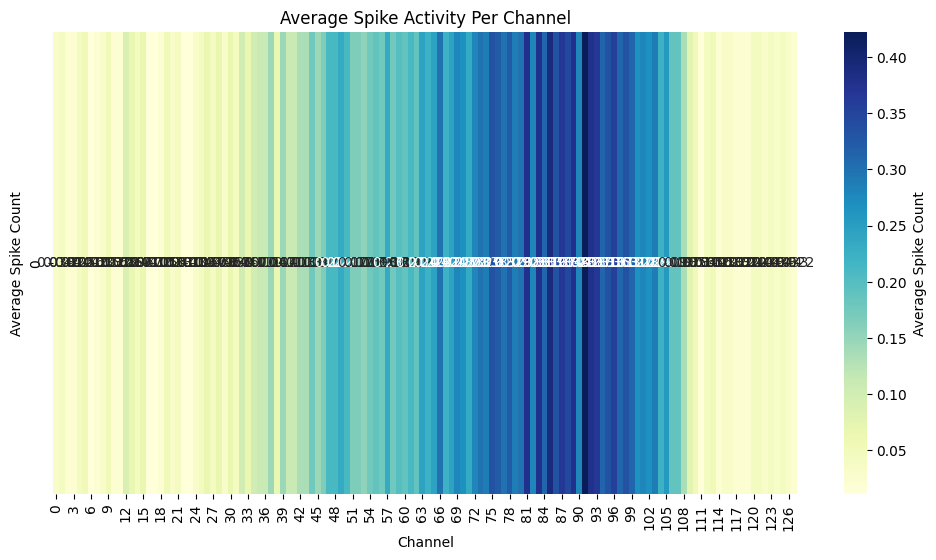

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average spike count across time steps for each channel
avg_spikes_per_channel = np.mean(sample_data, axis=0)  # Average spikes per channel across time steps

# Plot the results as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(avg_spikes_per_channel.reshape(1, -1), cmap="YlGnBu", annot=True, cbar_kws={'label': 'Average Spike Count'})
plt.title("Average Spike Activity Per Channel")
plt.xlabel("Channel")
plt.ylabel("Average Spike Count")
plt.show()

## Spike Rate vs. Time (Rate Coding Analysis)

This plot analyzes how the rate coding of a neuron evolves over time. A spike rate is defined as the number of spikes per time unit. By dividing the data into small temporal windows, you can analyze how the rate changes. This bar plot shows how the spike rate of each channel changes across the time window. This type of analysis can give you insights into the coding strategy of neurons in the network, such as rate coding.

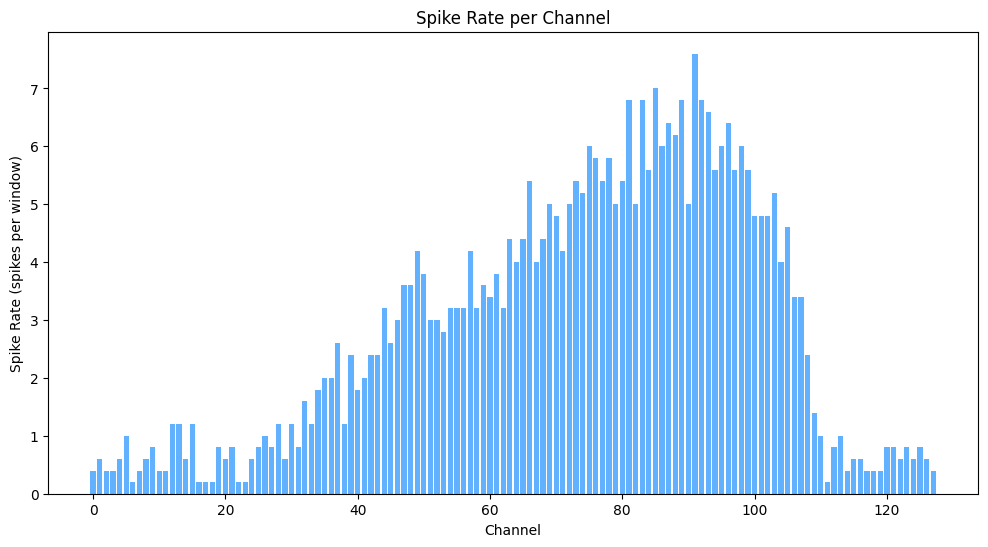

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Set the window size for calculating spike rate
window_size = 5  # in time steps

# Calculate the spike rate for each channel
spike_rate = np.sum(sample_data[:time_steps - window_size, :], axis=0) / window_size

plt.figure(figsize=(12, 6))
plt.bar(range(NET_CHANNELS), spike_rate, color="dodgerblue", alpha=0.7)
plt.xlabel("Channel")
plt.ylabel("Spike Rate (spikes per window)")
plt.title("Spike Rate per Channel")
plt.show()

## Spike Cross-Correlation (Neurons Working Together)

Cross-correlation can give insight into how two neurons (or channels) work together. It measures how the spiking of one neuron correlates with another over different time lags. This plot will show how spike patterns between two channels are related over different time lags. It is useful for analyzing temporal dependencies between neurons.


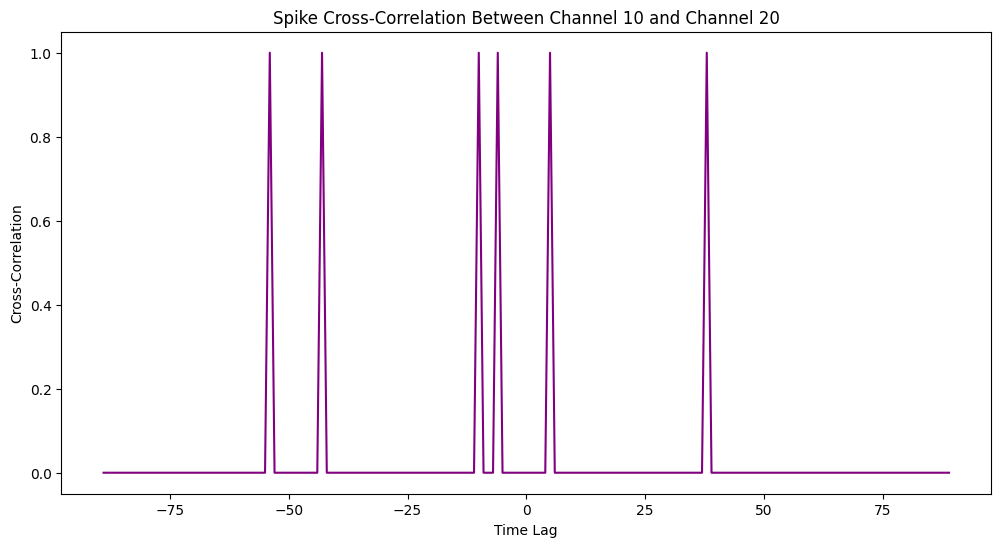

In [32]:
from scipy.signal import correlate

# Choose two channels for cross-correlation analysis
channel1 = sample_data[:, 10]  # Channel 10
channel2 = sample_data[:, 20]  # Channel 20

# Compute the cross-correlation between the two spike trains
cross_corr = correlate(channel1, channel2, mode="full", method="auto")

# Create a time axis for plotting
time_lags = np.arange(-len(channel1) + 1, len(channel1))

plt.figure(figsize=(12, 6))
plt.plot(time_lags, cross_corr, color="purple")
plt.xlabel("Time Lag")
plt.ylabel("Cross-Correlation")
plt.title("Spike Cross-Correlation Between Channel 10 and Channel 20")
plt.show()